In [1]:
import datetime
import json
import os
import random
import sys
import warnings
import pandas as pd

sys.path.append(os.path.join(os.getcwd(), '../../common'))
from ppg_feature_processor import generate_train_feature

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*Conversion of an array with ndim > 0 to a scalar is deprecated.*")

In [2]:
## 1)Read the university subjects and find the positive and negative subjects.

In [3]:
# 读取 Excel 文件
middleSchool_userProfile_file = r'../../ppg_depression/data_preprocess/outdir/MiddleSchool_Depression_Anxiety.xlsx'
university_userProfile_file = '../../../Data/healthy_scale_results.xlsx'  # 将此替换为您的 Excel 文件路径
hospital_userProfile_file = '../../../Data/unhealthy_clinic_results.xlsx'


In [4]:
### READ THE HOSPITAL SUBJECTS
df_hospital = pd.read_excel(hospital_userProfile_file)
print(df_hospital.columns)

hospital_positive_subjects_df = df_hospital[(df_hospital['焦虑'] == 1) & (df_hospital['年龄'] <= 20)][['床号', '性别', '年龄', '焦虑']]
print(hospital_positive_subjects_df)


hospital_positive_subjects = hospital_positive_subjects_df['床号'].tolist()
print("\nHospital Positive Depression subjects: ", hospital_positive_subjects)

Index(['床号', '性别', '年龄', '入院时间', '入院诊断', '病情备注', '抑郁', '焦虑', '双向情感障碍', '睡眠障碍'], dtype='object')
               床号 性别  年龄  焦虑
49  20240717_2A21  女  14   1
51  20240717_2A51  女  16   1

Hospital Positive Depression subjects:  ['20240717_2A21', '20240717_2A51']


In [5]:
df_university = pd.read_excel(university_userProfile_file, sheet_name='BAI')

valid_cols = df_university.columns.values[5::]
print("valid columns: ", valid_cols)

df_university['score'] = df_university[valid_cols].sum(axis=1)


university_positive_subjects_BAI = df_university[df_university['score'] >= 16]['ID'].tolist()
university_positive_subjects_BAI = []
print("University Positive Anxiety subjects: ", university_positive_subjects_BAI)

# Select the extrame subject to be the negative.
university_negative_subjects_BAI = df_university[df_university['score'] <= 0]['ID'].tolist()
university_negative_subjects_BAI = []
print("University Negative Anxiety subjects: ", university_negative_subjects_BAI)



valid columns:  ['1.身体麻木或刺痛' '2.感到发热' '3.腿部颤抖' '4.不能放松' '5.害怕要发生不好的事情' '6.感到头晕或眩晕'
 '7.心悸或心率加快' '8.心神不宁' '9.感到惊吓' '10.紧张' '11.有窒息感' '12.手发抖' '13.摇晃'
 '14.害怕失控' '15.呼吸困难' '16.害怕快要死去' '17.感到恐慌' '18.消化不良或腹部不适' '19.昏厥' '20.脸发红'
 '21.出汗（不是因为天气热）']
University Positive Anxiety subjects:  []
University Negative Anxiety subjects:  []


In [6]:
anxiety_positive_threshold = 15
anxiety_negative_threshold = 6

In [7]:
### READ THE MIDDLESCHOOL SUBJECTS
df_middle = pd.read_excel(middleSchool_userProfile_file)
df_middle = df_middle[(df_middle['anxiety_sum'] > anxiety_positive_threshold) | (df_middle['anxiety_sum'] < anxiety_negative_threshold)]
print(f"Midlle schold available subject count: {df_middle.shape}")


middle_pos_subjects = df_middle[df_middle['anxiety_sum'] > anxiety_positive_threshold]['user_id'].values.tolist()
middle_neg_subjects = df_middle[df_middle['anxiety_sum'] < anxiety_negative_threshold]['user_id'].values.tolist()

print(f"middle anxiety positive subjects count: {len(middle_pos_subjects)}")
print(f"middle anxiety negative subjects count: {len(middle_neg_subjects)}")

Midlle schold available subject count: (203, 108)
middle anxiety positive subjects count: 121
middle anxiety negative subjects count: 82


In [8]:
profile_dict = dict()

for _, row in df_hospital.iterrows():
    userId = row['床号']
    gender = 'Male' if row['性别'] == '男' else 'Female'
    age = row['年龄']
    profile_dict[userId] = (gender, age)

for _, row in df_university.iterrows():
    userId = row['ID']
    gender = 'Male' if row['Sex'] == '男' else 'Female'
    age = row['Age (years)']
    profile_dict[userId] = (gender, age)

for _, row in df_middle.iterrows():
    userId = row['user_id']
    gender = row['gender']
    age = 13
    profile_dict[userId] = (gender, age)

# for key, val in profile_dict.items():
#     print(f"userId: {key}, value: {val}")


In [9]:
random.shuffle(middle_pos_subjects)
random.shuffle(middle_neg_subjects)

test_subject_count = 15

test_pos_subjects = middle_pos_subjects[0:test_subject_count]
test_neg_subjects = middle_neg_subjects[0:test_subject_count]

train_pos_subjects = middle_pos_subjects[test_subject_count::] + university_positive_subjects_BAI + hospital_positive_subjects
train_neg_subjects = middle_neg_subjects[test_subject_count::] + university_negative_subjects_BAI

print(f"train postive subjects: {len(train_pos_subjects)}")
print(f"train negative subjects: {len(train_neg_subjects)}")

print(f"test postive subjects: {len(test_pos_subjects)}")
print(f"test negative subjects: {len(test_neg_subjects)}")


train postive subjects: 108
train negative subjects: 67
test postive subjects: 15
test negative subjects: 15


In [10]:
def load_wave_university_or_hospital(path):
    with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
            list_data = data['MesureData']['Datas']
            final = [i for i in list_data]
            return final

def load_wave_middleSchool(path):
    try:
        with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
            list_data = data['RawResults'][0]['rawDatas']
            final = [i/100000 for i in list_data]
        return final
    except (KeyError, IndexError, TypeError):
        with open(path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data["datas"]


In [11]:
sample_freq = 125
sample_window_minute = 0.5

university_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\healthy'
middle_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data'
hospital_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\unhealthy'

In [12]:
def generate_dataset(subject_collection, label, data_aug_times=1):
    ignored_id = []
    dataset = pd.DataFrame()
    for subject in subject_collection:
            subject_wave = []

            # The university subjects.
            if subject in (university_positive_subjects_BAI + university_negative_subjects_BAI):
                files = os.listdir(university_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(university_file_dir, file)
                        print(f"university file path: {file_path}")
                        tmp_wave = load_wave_university_or_hospital(file_path)
                        subject_wave += tmp_wave
            
            # The hospital subjects.
            elif subject in hospital_positive_subjects:
                files = os.listdir(hospital_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(hospital_file_dir, file)
                        print(f"hospital file path: {file_path}")
                        tmp_wave = load_wave_university_or_hospital(file_path)
                        subject_wave += tmp_wave
            
            # The middle school subjects.
            elif subject in (middle_pos_subjects + middle_neg_subjects):
                files = os.listdir(middle_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(middle_file_dir, file)
                        print(f"middle file path: {file_path}")
                        tmp_wave = load_wave_middleSchool(file_path)
                        subject_wave += tmp_wave

            if len(subject_wave) < (sample_freq * sample_window_minute * 60):
                ignored_id.append({'id': id, 'Time Length of data in minute ': f"{len(subject_wave)/(125 * 60):.02f}"})
                continue
            else:
                subject_dataset = generate_train_feature(subject, subject_wave, label, profile_dict[subject][0], profile_dict[subject][1], sample_freq, sample_window_minute, data_aug_times, if_gender = True)
                dataset = pd.concat([dataset, subject_dataset], ignore_index=True)
    return dataset


train_pos_dataset = generate_dataset(train_pos_subjects, label=1, data_aug_times=4)
train_neg_dataset = generate_dataset(train_neg_subjects, label=0, data_aug_times=2)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\38105743318352501687305527474372327912.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\68415645908804877552921659854931880952.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\181111116088821967589334728562514270873.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\206254331785533830049315502542703478728.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\260240317803029213106837561979534456162.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\270887533756973472376441335892518057033.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\29504840430026344791044389215920

In [13]:
test_pos_dataset = generate_dataset(test_pos_subjects, label=1, data_aug_times=1)
test_neg_dataset = generate_dataset(test_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\82498448730405369670702745834853438447.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\339322724187443127112522868306539161010.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\169726882416958308536333969983756283138.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\49652182019910863950272610697424552312.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\182500516767200798258395644582570054817.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\244837623397725739033827989374034931563.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\29153286560683864968524881112027

In [14]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (2926, 40)
train neg sample shape: (559, 40)
test pos sample shape: (73, 40)
test neg sample shape: (69, 40)


In [15]:
columns_drop = []
for col in train_pos_dataset.columns[:-4]:
    nan_count = (train_pos_dataset[col] == 0).sum() 
    if nan_count > (len(train_pos_dataset) // 4): 
        columns_drop.append(col)

train_pos_dataset_final = train_pos_dataset.drop(columns=columns_drop, inplace=False)
train_neg_dataset_final = train_neg_dataset.drop(columns=columns_drop, inplace=False)

test_pos_dataset_final = test_pos_dataset.drop(columns=columns_drop, inplace=False)
test_neg_dataset_final = test_neg_dataset.drop(columns=columns_drop, inplace=False)

In [16]:
print(f"After remove the invalid columns, train pos shape: {train_pos_dataset_final.shape}")
print(f"After remove the invalid columns, train neg shape: {train_neg_dataset_final.shape}")

print(f"After remove the invalid columns, test pos shape: {test_pos_dataset_final.shape}")
print(f"After remove the invalid columns, test neg shape: {test_neg_dataset_final.shape}")

After remove the invalid columns, train pos shape: (2926, 29)
After remove the invalid columns, train neg shape: (559, 29)
After remove the invalid columns, test pos shape: (69, 29)
After remove the invalid columns, test neg shape: (73, 29)


#### Do The Normalization for the Train Dataset and Test Dataset

In [17]:
profile_columns = ['wave_quality', 'age', 'gender', 'label', 'id']

In [18]:
# 合并训练集
train_combined = pd.concat([train_pos_dataset_final, train_neg_dataset_final])

# 需要归一化的列
columns_to_normalize = train_combined.columns.difference(profile_columns)

# 计算最大值和最小值
min_values = train_combined[columns_to_normalize].min()
max_values = train_combined[columns_to_normalize].max()

# 保存最大值和最小值到CSV
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
outdir = os.path.join(os.getcwd(), 'outdir')
os.makedirs(outdir, exist_ok=True)
min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})
min_max_df.to_csv(f'{outdir}/ppg_anxiety_norm_minmax_values
                  {current_date}.csv', index=True)


# 定义min-max归一化函数
def normalize(df, min_values, max_values):
    return (df - min_values) / (max_values - min_values)

# 对训练集进行归一化
train_pos_dataset_final[columns_to_normalize] = normalize(train_pos_dataset_final[columns_to_normalize], min_values, max_values)
train_neg_dataset_final[columns_to_normalize] = normalize(train_neg_dataset_final[columns_to_normalize], min_values, max_values)

# 从CSV文件中读取最小值和最大值
min_max_df = pd.read_csv(f'{outdir}/ppg_anxiety_norm_minmax_values{current_date}.csv', index_col=0)
min_values = min_max_df['min']
max_values = min_max_df['max']

# 对测试集进行归一化
test_pos_dataset_final[columns_to_normalize] = normalize(test_pos_dataset_final[columns_to_normalize], min_values, max_values)
test_neg_dataset_final[columns_to_normalize] = normalize(test_neg_dataset_final[columns_to_normalize], min_values, max_values)


#### Save As Pkl File

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

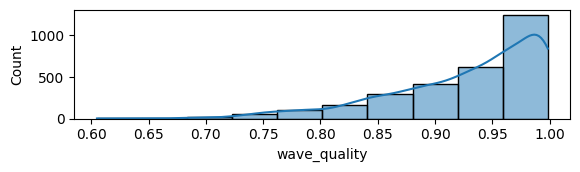

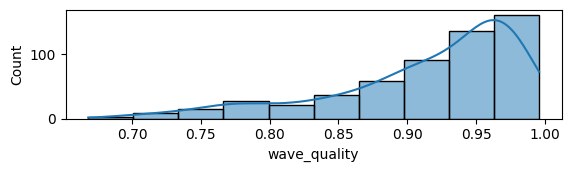

<Axes: xlabel='wave_quality', ylabel='Count'>

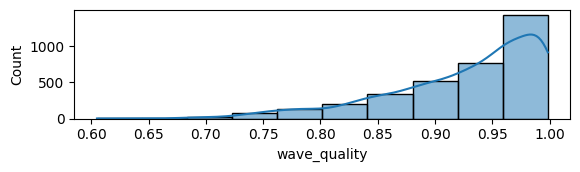

In [20]:
from matplotlib import figure

plt.subplot(3, 1, 1)  # 1行2列，第1个子图
sns.histplot(train_pos_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 2)  # 1行2列，第1个子图
sns.histplot(train_neg_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 3)  # 1行2列，第1个子图
sns.histplot(train_combined['wave_quality'], kde=True, bins=10)

In [21]:
wave_quality_threshold = 0.9

In [22]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (2926, 40)
train neg sample shape: (559, 40)
test pos sample shape: (73, 40)
test neg sample shape: (69, 40)


In [23]:
train_pos_dataset_final_filter = train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold]
train_neg_dataset_final_filter = train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold]

print(f"After quality filter, train positive sample count: {train_pos_dataset_final_filter.shape[0]}")
print(f"After quality filter, train negative sample count: {train_neg_dataset_final_filter.shape[0]}")


After quality filter, train positive sample count: 2084
After quality filter, train negative sample count: 383


In [24]:
sample_folder = os.path.join(os.getcwd(), 'samples')
os.makedirs(sample_folder, exist_ok=True)

# 定义要保存的文件路径
train_pos_path = os.path.join(sample_folder, 'train_pos_dataset.pkl')
train_neg_path = os.path.join(sample_folder, 'train_neg_dataset.pkl')
test_pos_path = os.path.join(sample_folder, 'test_pos_dataset.pkl')
test_neg_path = os.path.join(sample_folder, 'test_neg_dataset.pkl')

# 保存 DataFrame 为 .pkl 文件
train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_pos_path)
train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_neg_path)
test_pos_dataset_final[test_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(test_pos_path)
test_neg_dataset_final[test_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(test_neg_path)

In [25]:
print(train_pos_dataset_final.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'HRV_VHF',
       'HRV_TP', 'HRV_HFn', 'HRV_LnHF', 'wave_quality', 'label', 'id', 'age',
       'gender'],
      dtype='object')
